# *refellips* demo: User defined dielectric function

This demonstration presents an example on how to create and implement a user defined dielectric function. For this example we will be using the Gaussian oscillator from `refellips.structureSE.Gauss` to model a material's optical properties. We will then use this oscillator to calculate the ellipsometric parameters, $\Delta$ and $\Psi$, for a particular structure.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
import scipy.fftpack as ft  # FFT used in Hilbert Transform

In [3]:
import refellips, refnx

print(f"refellips: {refellips.__version__}\nrefnx: {refnx.__version__}")

refellips: 0.0.6.dev0+66630a3
refnx: 0.1.45


## Creating the dielectric function
Here we provide an example of how to create a *refellips* compatible dielectric function. We start be loading in the relevant packages from both *refellips* and *refnx*. The class must inherit from `ScattererSE` for later $\Delta$ and $\Psi$ calculations. For optical models containing multiple oscillators `refnx.analysis.sequence_to_parameters` will be especially useful.

In [4]:
from refellips import ScattererSE, nm_eV_conversion
from refnx.analysis import (
    Parameters,
    possibly_create_parameter,
    sequence_to_parameters,
)

We are now ready to create the class for our dielectric function: `Gauss`. This object will be composed of three functions: `__init__`, `parameters` and `epsilon`. The `epsilon` function is where the calculation of our complex dielectric function will take place.

In [5]:
class Gauss(ScattererSE):
    """
    Dispersion curves for Gaussian oscillators.

    Parameters
    ----------
    Am: {float, Parameter, sequence}
        Amplitude of Gaussian
    Br: {float, Parameter, sequence}
        Broadening of oscillator
    En: {float, Parameter, sequence}
        Centre energy of oscillator (eV)
    Einf: {float, Parameter}
        Offset term
    wavelength : float
        default wavelength for calculation (nm)
    name : str, optional
        Name of material.

    Notes
    -----
    Calculates dispersion curves for *k* Gaussian oscillators.
    The model is Kramers-Kronig consistent.
    The parameters for constructing this object should have
    `len(Am) == len(Br) == len(En) == k`, or be single float/Parameter.

    """

    # The Gauss oscillator takes 4 input parameters (Am, Br, En, Einf).
    # We must include these here. We must also supply a default wavelength.
    # However, we will easily be able to change this wavelength later.
    def __init__(self, Am, Br, En, Einf=1, wavelength=658, name=""):
        super().__init__(name=name, wavelength=wavelength)

        # Am, Br and En can be a sequence if more than one
        # Gaussian oscillator is employed. Here we use the
        # `sequence_to_parameters` function from *refnx* to create
        # these parameters.
        self.Am = sequence_to_parameters([Am])
        self.Br = sequence_to_parameters([Br])
        self.En = sequence_to_parameters([En])

        # We must also make sure that the number of supplied
        # amplitudes/broadening/location parameters are all the same.
        if not (len(self.Am) == len(self.Br) == len(self.En)):
            raise ValueError("A, B, E all have to be the same length")

        # Einf is a float, not a sequence, so we use
        # `possibly_create_parameter` from *refnx* for that.
        self.Einf = possibly_create_parameter(Einf)

        # We then append all parameters to `_parameters`.
        self._parameters = Parameters(name=name)
        self._parameters.extend([self.Am, self.Br, self.En])
        self._parameters.append(self.Einf)

    # The `parameters` property returns all the `Parameter`
    # contained in the class.
    @property
    def parameters(self):
        return self._parameters

    # The `epsilon` method calculates the complex dielectric
    # function of our material. The method takes an energy in *eV*
    # which can be converted to wavelength in nm using
    # `refellips.structureSE.nm_to_eV`. `energy` can be a float or
    # a numpy array.
    def epsilon(self, energy):
        """
        The complex dielectric function for the oscillator
        """

        # Convert the sequence of each of the Gaussian properties to a
        # numpy array. self.Am, etc, are a `refnx.parameters.Parameters`
        # object.
        A = np.array(self.Am)
        B = np.array(self.Br)
        E = np.array(self.En)
        energies = np.asarray(energy, np.float64)

        # Here we calculate the value of $\varepsilon_2$ (`e2`)
        # for a Gaussian oscillator over a given energy window;
        # here we have chosen from -20 eV to 20 eV. This range
        # is left to the discretion of the user. We will later
        # interpolate the to obtain values at the requested energies.
        # The calculation is done in a vectorised manner for speed.
        _e_pad = np.linspace(-20, 20, 2048)
        sigma = B / 2 / np.sqrt(np.log(2))
        e2 = A[:, None] * np.exp(
            -(((_e_pad - E[:, None]) / sigma[:, None]) ** 2)
        )
        e2 -= A[:, None] * np.exp(
            -(((_e_pad + E[:, None]) / sigma[:, None]) ** 2)
        )
        e2 = np.sum(e2, axis=0)
        # We have now calculated `e2`.

        # We will now determine the value of $\varepsilon_1$ (`e1`),
        # which is Kramers-Kronig consistent, via a Hilbert transform.
        # If your oscillator/model describing the optical properties
        # of your material is not Kramers-Kronig consistent, you can
        # simply provide an equation for `e1`.
        e1 = ft.hilbert(e2) + self.Einf.value

        # Now that we have expressions for both `e1` and `e2` across a
        # given energy window from -20 eV to 20 eV, we can (linearly)
        # interpolate to find $\varepsilon$ at given energy. Here we
        # simply use np.interp to interpolate $varepsilon.
        _e1 = np.interp(energies, _e_pad, e1)
        _e2 = np.interp(energies, _e_pad, e2)

        # We're now done and ready to return the requested $\varepsilon$.
        # We will only return a single (complex) value for
        # $\varepsilon$ if only 1 energy was requested.
        r = np.atleast_1d(_e1 + 1j * _e2)
        if np.isscalar(energy) and len(r) == 1:
            return r[0]
        return r

## Calculating the complex dielectric function

### Creating the wavelength/energy range
Now that we have created the class `Gauss` to describe the optical properties of our material, we can create the wavelength range (in nm) that we wish to model. This will be converted from nm to eV to establish an energy range.

In [6]:
wavelength_range = np.linspace(250, 1100, 250)
energy_range = nm_eV_conversion(wavelength_range)

### Creating the Gauss object
We now create sequences that describe the Gaussian oscillators. This example will use 3 oscillators.

In [7]:
Am = [2, 0.5, 1]
Br = [0.75, 0.5, 0.6]
En = [0.6, 2, 1.2]
Einf = 1

In [8]:
gauss = Gauss(Am, Br, En, Einf)

### Plotting $\varepsilon$ as a function of energy
Now that we have an object `gauss` and an `energy_range`, we can call `gauss.epsilon(energy_range)` to provide the relating complex dielectric function, $\varepsilon$. We will split $\varepsilon$ into its real and imaginary components `e1` and `e2` and plot as a function of energy.

In [9]:
e = gauss.epsilon(energy_range)
e1 = e.real
e2 = e.imag

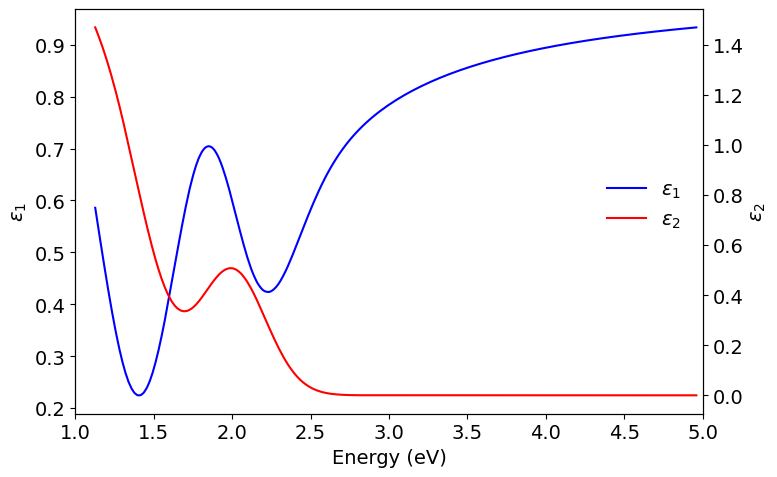

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(energy_range, e1, c="blue", label="$\\varepsilon_1$")

axt = ax.twinx()
axt.plot(energy_range, e2, c="red", label="$\\varepsilon_2$")

ax.set(ylabel="$\\varepsilon_1$", xlabel="Energy (eV)", xlim=(1, 5))
axt.set_ylabel("$\\varepsilon_2$")

fig.legend(loc=(0.77, 0.5), bbox_transform=ax.transAxes, frameon=False)
fig.tight_layout()

## Plotting $n, k$ as a function of wavlength
We can now calculate the refractive indices (`n`) and extinction coefficients (`k`) of our material from `e` and plot as a function of wavelength. You can also request this from the `Gauss` object by using the `complex` method, `gauss.complex(wavelength_range)`.

In [11]:
ri = np.sqrt(e)

n = ri.real
k = ri.imag

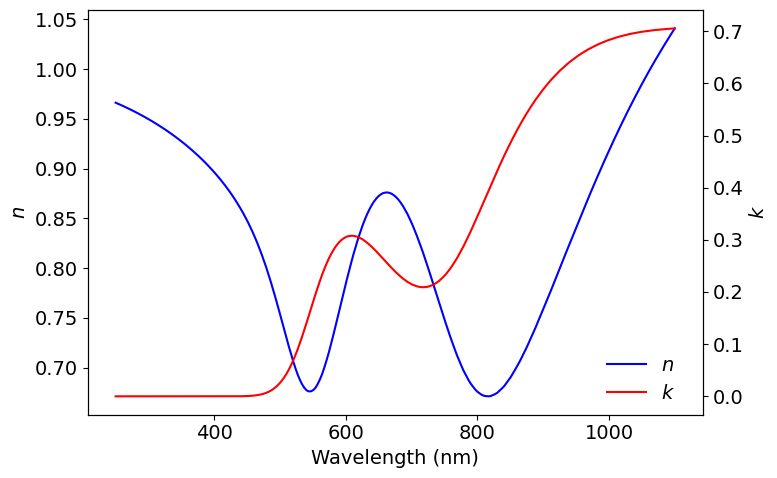

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(wavelength_range, n, c="blue", label="$n$")

axt = ax.twinx()
axt.plot(wavelength_range, k, c="red", label="$k$")

ax.set(ylabel="$n$", xlabel="Wavelength (nm)")
axt.set_ylabel("$k$")

fig.legend(loc=(0.77, 0.14), bbox_transform=ax.transAxes, frameon=False)
fig.tight_layout()

## Calculating $\Delta$ and $\Psi$
Now that we have a way of describing the complex dielectric function of a component within our sample (i.e., `Gauss`), we can now calcuate the ellipsometric parameters $\Delta$ and $\Psi$. We'll need to load some more packages first.

In [13]:
from refellips import load_material
from refellips.reflect_modelSE import ReflectModelSE

Let's start by constructing the structure and model describing our interface. Let's say our system has a native oxide silica layer of 20 Å and a film thickness, which will be described by our defined Gauss oscillator, of 1800 Å. Let's start by defining each of our components.

In [14]:
si = load_material("silicon")
sio2 = load_material("silica")
air = load_material("air")

Am = [1.3, 0.9]
Br = [0.8, 0.6]
En = [1.4, 2.8]
Einf = 2

film = Gauss(Am, Br, En, Einf)
film_layer = film(1800)
film_layer.thick.setp(vary=False, bounds=(100, 5000))

We can now assemble the components and define the structure.

In [15]:
struc = air() | film_layer | sio2(20) | si()

Finally, we create the model.

In [16]:
model = ReflectModelSE(struc)

Now let's plot the results for a single wavelength across various angles of incidence.

In [17]:
aoi = np.linspace(40, 65, 50)
wavelength = [650]

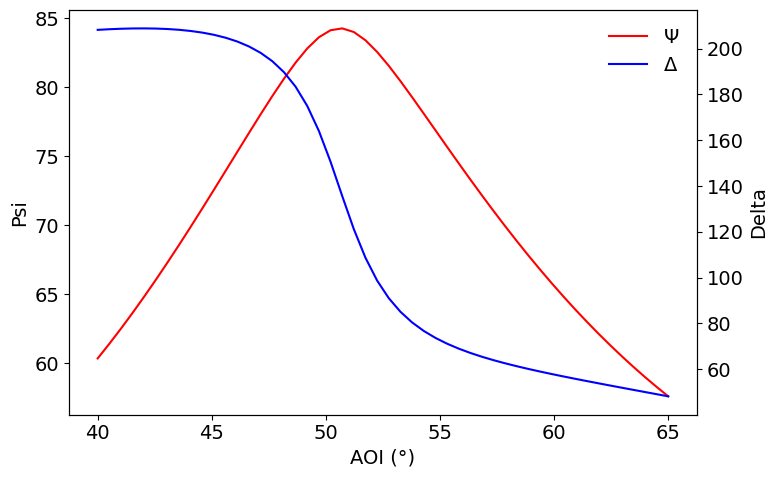

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
axt = ax.twinx()

for idx, wav in enumerate(wavelength):
    psi, delta = model(np.c_[np.ones_like(aoi) * wav, aoi])
    (p,) = ax.plot(aoi, psi, color="r")
    (d,) = axt.plot(aoi, delta, color="b")

ax.legend(handles=[p, d], labels=[r"$\Psi$", r"$\Delta$"], frameon=False)
ax.set(ylabel="Psi", xlabel="AOI (°)")
axt.set(ylabel="Delta")
fig.tight_layout()